This notebook is intended as a companion to the paper "Robust inference of neutron-star parameters from thermonuclear burst observations" by D. K. Galloway et al., and includes simple examples of using methods as part of the `concord` repository to demonstrate the inference of neutron star properties & burst fuel composition from observations and comparison with simulated data. 

The sections below largely follow the discussion in the paper, and include examples of data analysis from 
1. 4U 0513+40
1. Kepler simulations
1. 4U 1820-303 (might later replace with GS 1826-24)
1. XMMU J181227.8-181234 (= XTE J1812-182)
1. IGR J17591-2342
1. IGR J00291+5934
1. _and possibly_ SAX J1810.8-2609

The analysis approaches are broken into cases depending on the extent of the available data; e.g. pairs (or trains) of bursts with well-constrained recurrence times, all the way down to no bursts at all. See below for these examples

The notebook has been tested with the following packages:
* `python` 3.8.5
* `matplotlib` 3.4.3
* `astropy` 5.0
* `ChainConsumer` 0.33.0
* `astroquery` 0.4.1

### Modification history

27/1/2022 - The Kepler run information is now read in from a machine-readable table that will be distributed with the paper (and concord repository)

### Future work

To do before submitting the paper:
* Expand the references to proper links, and in-line citations
* Clean up the code and comments, and remove extraneous stuff
* Add in a routine to do the distance estimate as for XMMU J181227.8-181234, where you compare the mdot implied by the burst recurrence time to the persistent flux

In [1]:
import concord as cd

from astropy.io import ascii
from astropy.table import Table
import pandas as pd

import astropy.constants as const
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support 
import astropy.uncertainty as unc

from chainconsumer import ChainConsumer
from numpy.random import normal, multivariate_normal
#from math import *
import math

%matplotlib inline

flux_unit = u.erg/u.cm**2/u.s
mdot_Edd = 8.8e4*u.g/u.cm**2/u.s

# Just checking

import sys
print ('Python version {}'.format(sys.version))

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

import astropy
print('astropy version {}'.format(astropy.__version__))

Python version 3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) 
[Clang 6.0 (clang-600.0.57)]
matplotlib: 3.4.3
astropy version 5.0


## 2.1 Emission anisotropy

Here we illustrate the various anisotropy factors as a function of system inclination. A call to the `anisotropy` routine with `test=True` will generate this plot

/Users/duncan/projects/concord/concord/diskmodel.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Example anisotropy values for i=30: xi_b = 0.7187, xi_p = 0.4934


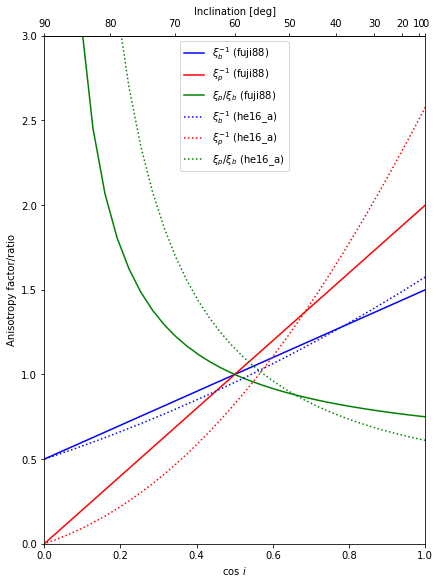

In [2]:
xi_b, xi_p = cd.anisotropy(30*u.degree,test=True)
print ('Example anisotropy values for i=30: xi_b = {:.4f}, xi_p = {:.4f}'.format(xi_b, xi_p))

# plt.savefig("anisotropy.pdf", bbox_inches='tight')

## 2.3 Burst energetics and fuel composition

Here we derive the expected ranges for the $\alpha$-value for conservative burning, for a $1.4\ M_\odot$ neutron star with $R=11.6$ km

In [5]:
qnuc_He = cd.Q_nuc(0.)
qnuc_solar = cd.Q_nuc(0.7)

qgrav = (const.c**2*(cd.OPZ-1)/cd.OPZ).to('MeV g-1')*const.m_p.to('g')

print ('Expected range of alpha-value (excluding anisotropy effects) is {:.1f}-{:.1f}'.format(
    qgrav/(qnuc_solar*u.MeV), qgrav/(qnuc_He*u.MeV)))

Expected range of alpha-value (excluding anisotropy effects) is 36.9-147.9


Typically the average H-fraction at ignition $\overline{X}$ is reduced below the accreted value $X_0$ by the effects of steady hot-CNO burning. Here we use equations 14-16 to illustrate the relationshi between the two, for various cases of recurrence time and $Z_\mathrm{CNO}$

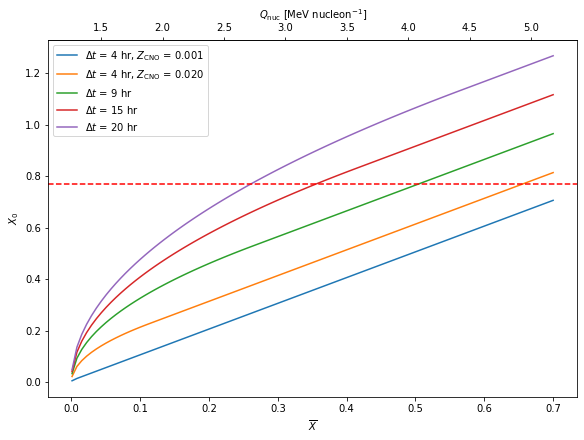

In [6]:
# Generate an array of Xbar values

nsamp = 100
Xbar_arr = np.linspace(0.001,0.7,nsamp)
Xbar_arr

x_0 = np.zeros(nsamp)
Z_CNO = 0.001 # CNO metallicity for the first line; we switch to "solar" after that
#dt1 = 4.*u.hr
dt_array = np.linspace(4.,20.,4)
dt_array = np.insert(dt_array,0,4.)

fig, ax = plt.subplots(constrained_layout=True)

# Loop over each of the recurrence time values, and plot the line
for j, dt1 in enumerate(dt_array):
    for i in range(nsamp):
        # print (i,Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))
        x_0[i] = cd.X_0(Xbar_arr[i],Z_CNO,dt1*u.hr)

    if j <= 1:
        ax.plot(Xbar_arr, x_0, label='$\Delta t$ = {:.0f} hr, $Z_\mathrm{{CNO}}$ = {:.3f}'.format(
            dt1, Z_CNO))
    else:
        ax.plot(Xbar_arr, x_0, label='$\Delta t$ = {:.0f} hr'.format(dt1))

    
    Z_CNO = 0.02
ax.set_xlabel("$\overline{X}$")
ax.set_ylabel("$X_0$")
ax.axhline(0.77,linestyle='--',color='r')

def Xbar(qnuc):
    '''
    Inverse function to Q_nuc, to generate the secondary axis
    '''
    
    q = cd.Q_nuc(0.,quadratic=False, coeff=True)
                 
    return (qnuc-q[0])/q[1]

secax = ax.secondary_xaxis('top', functions=(cd.Q_nuc, Xbar))
secax.set_xlabel("$Q_\mathrm{nuc}$ [MeV nucleon$^{-1}$]")
ax.legend()

fig.set_size_inches(8,6)
# fig.savefig("xbar.pdf", bbox_inches='tight')

## 3. Peak luminosity of a burst

This section provides a simple introduction to the routines of the code and how incorporating the astrophysical uncertainties can affect the measurements. We adopt measurements of peak flux for a burst from 4U 0513+40 measured by _RXTE_, as part of the MINBAR sample ([Galloway et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..249...32G)); the distance measurement for the host cluster NGC 1851 from [Watkins et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...812..149W); and the lower limit on the system inclination from [Fiocchi et al. (2011)](http://adsabs.harvard.edu/abs/2011MNRAS.414L..41F).

In [7]:
d = (10.32, 0.24, 0.20) # asymmetric errors from Watkins et al. 2015
imin, imax = 80, 90 # degrees assumed

# Retrieve the burst measurements from MINBAR

import minbar as mb

b = mb.Bursts()
id = 3443 # burst from 4U~0513-40 with RXTE/PCA on MJD 54043.68857 obsID 92403-01-15-04
F_pk, F_pk_err = b[id]['bpflux'], b[id]['e_bpflux']
print ('''Burst #{}, observed from {} on MJD {:.5f} (obsid {});
  Peak (bolometric) flux is {:.2f} +/- {:.2f} E-9 erg/cm^2/s'''.format(
    id, b[id]['name'], b[id]['time'], b[id]['obsid'], F_pk, F_pk_err))

# Now calculate the various luminosities
# In the absence of units for the flux, MINBAR units are assumed; in this case 1e-9 erg/cm^2/s
l_iso = cd.luminosity( F_pk, dist=d[0], isotropic=True )

# For the MCMC version, we use 10000 samples (1000 is the default) to get smoother 
# distributions for final values
l_asym = cd.luminosity( (F_pk, F_pk_err), dist=d, burst=True, imin=imin, imax=imax, 
                        fulldist=True, nsamp=10000)
lc = l_asym['lum'].pdf_percentiles([50, 50 - cd.CONF / 2, 50 + cd.CONF / 2])

l_unit = 1e38*u.erg/u.s
print ('''\nIsotropic luminosity is {:.2f}e38 erg/s
  Taking into account anisotropy, ({:.2f}-{:.2f}+{:.2f})e38 erg/s'''.format(l_iso/l_unit, 
                                                                            lc[0]/l_unit, 
                                                (lc[0]-lc[1])/l_unit, (lc[2]-lc[0])/l_unit))

Burst #3443, observed from 4U 0513-40 on MJD 54043.68857 (obsid 92403-01-15-04);
  Peak (bolometric) flux is 21.72 +/- 0.60 E-9 erg/cm^2/s

Isotropic luminosity is 2.77e38 erg/s
  Taking into account anisotropy, (4.85-0.43+0.47)e38 erg/s


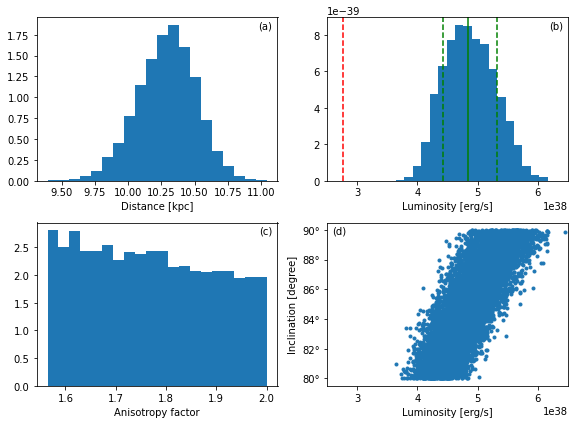

In [8]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python

fig0, axs0 = plt.subplots(2, 2)
fig0.set_size_inches(8,6)

with quantity_support():
    axs0[0, 1].hist(l_asym['lum'].distribution,bins=20,density=True, 
         label='Luminosity (erg/s)')
    axs0[0, 1].axvline(l_iso,color='r',ls='--')
    axs0[0, 1].axvline(lc[1],color='g',ls='--')
    axs0[0, 1].axvline(lc[2],color='g',ls='--')
    axs0[0, 1].set_xlim((2.5e38,6.5e38))
    axs0[0, 1].set_xlabel('Luminosity [erg/s]')
    axs0[0, 1].axvline(lc[0],color='g')
    
    axs0[0, 1].text(0.95, 0.95, '(b)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,1].transAxes)

    axs0[0,0].hist(l_asym['dist'].distribution, bins=20, density=True)
    axs0[0,0].set_xlabel('Distance [kpc]')
    
    axs0[0, 0].text(0.95, 0.95, '(a)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,0].transAxes)

    axs0[1,1].plot(l_asym['lum'].distribution, l_asym['i'].distribution, '.')
    # axs0[1,1].set_xlim((2.5e38,6.5e38))
    axs0[1, 1].sharex(axs0[0, 1])
    axs0[1,1].set_xlabel('Luminosity [erg/s]')
    axs0[1,1].set_ylabel('Inclination [degree]')

    axs0[1, 1].text(0.05, 0.95, '(d)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,1].transAxes)

    axs0[1,0].hist(l_asym['xi'].distribution, bins=20, density=True)
    axs0[1,0].set_xlabel('Anisotropy factor')

    axs0[1,0].text(0.95, 0.95, '(c)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,0].transAxes)


fig0.tight_layout()
# fig0.savefig("fig0.pdf", bbox_inches='tight')

# 3.1 Code validation
_previously: "Inferring Xbar"_ 

As a preliminary test for the relations in the paper, we use the set of "xbar" Kepler runs as for [Goodwin et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...870...64G), which have a measured $\overline{X}$ (mean H-fraction at ignition).

These data can be found in the local directory `concord/kepler`. The latest (2021 Nov) version of this analysis omits the lightcurve analysis and simply uses the predicted burst energy and recurrence time, along with the mdot to give the persistent flux.

Lightcurve files seem to be some binary format, I don't know how to read them. Asked Adelle (8/10/18)

<TableColumns names=('run','mdot','X','Z','n_burst','n_avg','y','trec','e_trec','fluen','e_fluen','Xbar','e_Xbar','Xign')>

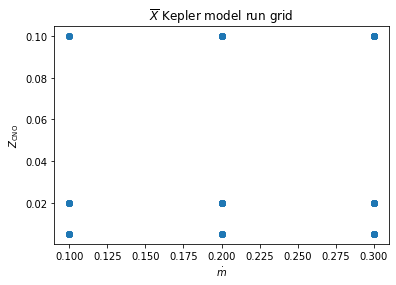

In [29]:
# Since we moved all the cells used to create the .mrt file to the "Testing & Development"
# notebook, we just read the .mrt file here instead
#
# The .mrt file is NOT YET part of the repository (but will be) -- 2022 Jan

ft = ascii.read('kepler_xbar.mrt')#, format='mrt')

plt.scatter(ft['mdot'],ft['Z'])
plt.xlabel('$\dot{m}$')
plt.ylabel('$Z_\mathrm{CNO}$')
plt.title('$\overline{X}$ Kepler model run grid')

ft.columns

First step is to test our Xbar calculation, to make sure our simple equations can replicate (approximately) what is measured from the Kepler models

In [33]:
# Instead we can implement equations 13 and 14, neglecting the redshift factor, because
# the t_CNO (along with the recurrence time) are all measured in the NS frame

ft['t_CNO'] = 9.8*(ft['X']/0.7)/(ft['Z']/0.02) # hr

ft['f_burn'] = ft['trec']/ft['t_CNO']
ft['xbar_inf'] = ft['X']*(1-0.5*ft['f_burn'])
# exh = np.where(full_table['average recurrence time (s)']/3600. > full_table['t_CNO'])[0]
exh = np.where(ft['trec'] > ft['t_CNO'])[0]

# full_table['xbar_inf'][exh] = full_table['X'][exh]
# full_table.loc[exh]['xbar_inf'] = 0.5*full_table.loc[exh]['X']/full_table.loc[exh]['f_burn']

ft['xbar_inf'][exh] = 0.5*ft[exh]['X']/ft[exh]['f_burn']

In [34]:
# ... and our Xbar - X_0 function

ft['X_inf'] = [cd.X_0(ft['Xbar'][i], ft['Z'][i], 
                           ft['trec'][i]*ft['trec'].unit) 
                       for i in range(len(ft))]

Xbar RMS error: 0.0249
  for low Xbar: 0.0448
X_0 RMS error, excluding outliers: 0.0209


X,Z,mdot,n_burst,Xbar,e_Xbar,trec
,,,,,,h
float64,float64,float64,int64,float64,float64,float64
0.2,0.1,0.3,27,0.05115,0.02982,1.138
0.2,0.1,0.3,26,0.0516,0.03037,1.136
0.2,0.1,0.3,23,0.05287,0.03216,1.123
0.2,0.1,0.2,21,0.02996,0.03902,2.62
0.3,0.1,0.2,14,0.07959,0.06646,1.984
0.2,0.1,0.3,60,0.08376,0.06712,1.12
0.2,0.02,0.1,40,0.09593,0.07359,6.164
0.2,0.1,0.1,40,0.10195,0.09805,16.699


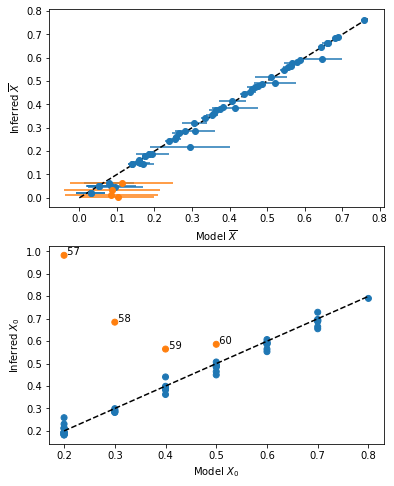

In [35]:
# here identify the "bad" values of X_0_inf

ex = abs(ft['X']-ft['X_inf']) > 0.075

# ... and set up a colour array to plot them
# https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

col = ['C1' if x else 'C0' for x in ex]

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(2)
fig.set_size_inches(6,8)

# Want to show the horizontal error bars to illustrate the  burst-to-burst variations
# in the simulation results
# axs[0].scatter(ft['Xbar'],ft['xbar_inf'],c=col)
iex = np.where(~ex)[0]
axs[0].errorbar(ft['Xbar'][iex],ft['xbar_inf'][iex],xerr=ft['e_Xbar'][iex],fmt='o')
iex = np.where(ex)[0]
axs[0].errorbar(ft['Xbar'][iex],ft['xbar_inf'][iex],xerr=ft['e_Xbar'][iex],fmt='o')

axs[0].plot([0.0, 0.77], [0.0, 0.77], 'k--')
axs[0].set_xlabel('Model $\overline{X}$')
axs[0].set_ylabel('Inferred $\overline{X}$')
# plt.ylim(-0.4, 0.79)

# mark the problematic ones from the next plot

# ex = np.where((full_table['run no.'] >= 57) & (full_table['run no.'] <=60))[0]
# for i in ex:
#     # print (i, full_table.iloc[i]['run no.'], full_table.iloc[i]['xbar'], full_table.iloc[i]['xbar_inf'])
#     axs[0].annotate(' {:.0f}'.format(full_table.iloc[i]['run no.']), 
#         (full_table.iloc[i]['xbar'], full_table.iloc[i]['xbar_inf']))
    
# quantify the error here

xbar_rms = np.sqrt(np.mean((ft['Xbar']-ft['xbar_inf'])**2))
print ('Xbar RMS error: {:.4f}'.format(
    xbar_rms))
loX = np.where(ft['Xbar'] < 0.13)[0]
print ('  for low Xbar: {:.4f}'.format(
    np.sqrt(np.mean((ft['Xbar'][loX]-ft['xbar_inf'][loX])**2))))

# Second plot

axs[1].scatter(ft['X'], ft['X_inf'], c=col)

axs[1].plot([0.2, 0.8], [0.2, 0.8], 'k--')
axs[1].set_xlabel('Model $X_0$')
axs[1].set_ylabel('Inferred $X_0$')

# https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

for i in np.where(ex)[0]:
    # print (i, full_table.iloc[i]['run no.'], full_table.iloc[i]['X'], full_table.iloc[i]['X_inf'])
    axs[1].annotate(' {}'.format(ft['run'][i]), 
        (ft['X'][i], ft['X_inf'][i]))
    
# quantify the error here

excl = np.where((ft['run'] < 57) | (ft['run'] > 60))[0]
X_0_rms = np.sqrt(np.mean((ft['X'][excl]-ft['X_inf'][excl])**2))
print ('X_0 RMS error, excluding outliers: {:.4f}'.format(
    X_0_rms))
# print ('for low Xbar: {:.4f}'.format(
#     np.sqrt(np.mean((full_table.loc[loX]['xbar']-full_table.loc[loX]['xbar_inf'])**2))))

# fig.savefig("validation.pdf", bbox_inches='tight')

ft[['X','Z','mdot','n_burst','Xbar','e_Xbar','trec']][loX]

this actually looks pretty good! The four most significant outliers are at the low-accretion rate (0.1 mdot_Edd) and high Z_CNO (0.1). Are these the only ones that are getting to very low xbar?

No, we have a handful getting to lower xbar

In [11]:
# full_table[full_table['runid'] >= 57]
ft.sort_values('xbar')[:10]


AttributeError: 'Table' object has no attribute 'sort_values'

In [12]:
# The way the units are applied in this table is a little flaky

ft['fluen'].unit

print ((ft['fluen'][0],ft['e_fluen'][0])*ft['fluen'].unit/u.s)

# testing
cd.lum_to_flux( (ft['fluen'][0]*1e38,ft['e_fluen'][0]*1e38)*u.erg/u.s, 
               dist=d, burst=True, dip=False,
               isotropic=False, inclination=res_arr[2,i*n_per_run+j], fulldist=True)

[25.12  0.84] 1e+38 erg / s


NameError: name 'res_arr' is not defined

Now we do a more realistic simulation, choosing randomly-distributed inclinations, looping over the available models, and generate some random samples for each one

Taking things simple at this point and keeping redshift and radius fixed

In [13]:
n_rows = len(ft)
n_per_run = 10

# keep fixed redshift and bolometric correction for now

opz = cd.OPZ
R_NS = 11.2*u.km
d = 6*u.kpc
bol_corr = 1.4

# Generate an array of inclinations

# i = 50*u.deg
i = cd.iso_dist(nsamp=n_per_run*n_rows)

# Define the result array
# columns are run ID, X_sim, inclination, X_meas, X_meas_lo, X_meas_hi]

res_arr = np.zeros((6,n_per_run*n_rows))
res_arr[2,:] = i.distribution
# res_arr

for i in range(n_rows):
# for i in range(n_rows):
# for i in range(3): # for testing
    print ('Simulating run id {}...'.format(ft['run'][i]))
    
    # summ_row = np.where(summary_table["run no."] == i+1)[0][0]
    # param_row = np.where(xbar_table["runid"] == i+1)[0][0]
    # print (summ_row,param_row)

    # Now transform the data into observations, given a distance, redshift and inclination
    # Recurrence time

    # tdel = ((summary_table["average recurrence time (s)"][summ_row], 
    #         summary_table["recurrence time error"][summ_row] ) * u.s).to('hr')
    tdel = (ft['trec'][i], ft['e_trec'][i])*u.hr
    tdel *= opz

    # mdot_Edd = 8.8e4*1.7/(1+xbar_table['X'][param_row])*u.g/u.cm**2/u.s
    mdot_Edd = 8.8e4*1.7/(1+ft['X'][i])*u.g/u.cm**2/u.s
    for j in range(n_per_run):
        
        res_arr[0,i*n_per_run+j] = ft['run'][i]
        res_arr[1,i*n_per_run+j] = ft['X'][i]
        # res_arr[1,i*n_per_row+j] = xbar_table['X'][param_row]
        # res_arr[2,i*n_per_row+j] = xbar_table['xbar'][param_row]
        
        # Fluence
        # Transforms the same way as flux, but we have to add (and then remove) seconds as
        # a unit to get the right dimensions

        e_b = cd.lum_to_flux( (ft["fluen"][i]*1e38, 
                               ft['e_fluen'][i]*1e38)*u.erg/u.s, dist=d, burst=True, dip=False,
                        isotropic=False, inclination=res_arr[2,i*n_per_run+j], fulldist=True)
    
        # e_b = cd.lum_to_flux( (summary_table["average fluence (erg/s)"][summ_row], 
        #                        summary_table["fluence error"][summ_row])*u.erg/u.s, dist=d, burst=True, dip=False,
        e_b = e_b["flux"]*u.s

        # Persistent flux
        # Need to work out what mdot is in real physical units to use this

        mdot = (ft['mdot'][i]*mdot_Edd*4*math.pi*R_NS**2).to('g s-1')
        # mdot = (xbar_table["accrate"][param_row]*mdot_Edd*4*math.pi*R_NS**2).to('g s-1')

        fper = cd.fper(mdot, (d, res_arr[2,i*n_per_run+j], opz, 0.0), c_bol=bol_corr)

        xbar = cd.hfrac(tdel, fper=fper, fluen=e_b, c_bol=bol_corr,
                  isotropic=False, inclination=None, fulldist=True)

        # save results; now X_0 might have -1 values, so trap those here
        
        gz = np.where(xbar['X_0'].distribution >= 0.)[0]
        if len(gz) > 2:
        
            xpc = np.percentile(xbar['X_0'].distribution[gz],(50,16,84))
            res_arr[3,i*n_per_run+j] = xpc[0]
            res_arr[4,i*n_per_run+j] = xpc[0]-xpc[1]
            res_arr[5,i*n_per_run+j] = xpc[2]-xpc[0]

Simulating run id 1...


Simulating run id 2...


Simulating run id 3...


Simulating run id 4...


Simulating run id 5...


Simulating run id 6...


Simulating run id 7...


Simulating run id 8...


Simulating run id 9...


Simulating run id 10...


Simulating run id 11...


Simulating run id 12...


Simulating run id 13...


Simulating run id 14...


Simulating run id 15...


Simulating run id 16...


Simulating run id 17...


Simulating run id 18...


Simulating run id 19...


Simulating run id 20...


Simulating run id 21...


Simulating run id 22...


Simulating run id 23...


Simulating run id 24...


Simulating run id 25...


Simulating run id 26...


Simulating run id 27...


Simulating run id 28...


Simulating run id 29...


Simulating run id 31...


Simulating run id 32...


Simulating run id 33...


Simulating run id 34...


Simulating run id 35...


Simulating run id 36...


Simulating run id 37...


Simulating run id 38...


Simulating run id 39...


Simulating run id 40...


Simulating run id 41...


Simulating run id 42...


Simulating run id 43...


Simulating run id 44...


Simulating run id 45...


Simulating run id 46...


Simulating run id 47...


Simulating run id 48...


Simulating run id 49...


Simulating run id 50...


Simulating run id 51...


Simulating run id 52...


Simulating run id 53...


Simulating run id 54...


Simulating run id 55...


Simulating run id 56...


Simulating run id 57...


Simulating run id 58...


Simulating run id 59...


Simulating run id 60...


Simulating run id 63...


<TableColumns names=('run','mdot','X','Z','n_burst','n_avg','y','trec','e_trec','fluen','e_fluen','Xbar','e_Xbar','Xign','X_inf','t_CNO','f_burn','xbar_inf')>
X_0 RMS error: 0.0975
X_0 RMS error low Z: 0.0519


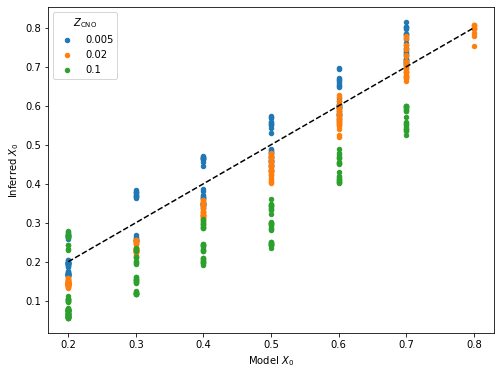

In [36]:
# If we convert to a DataFrame, we can do some more useful stuff
# But we first need to also convert the simulation table to a DataFrame

print(ft.columns)
ft_df = ft.to_pandas()
# ft_df

# np.shape(res_arr)
ra = pd.DataFrame(res_arr.T, columns=['run', 'X', 'inclination', 'X_meas', 'X_meas_lo', 'X_meas_hi'])
ra = pd.merge(ra, ft_df, on='run')

# Now plot the results
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (8,6)
fig.set_size_inches(8,6)
colors = {0.005: 'C0', 0.02: 'C1', 0.1: 'C2'}
res_arr[:,:30]
# plt.scatter(res_arr[1,:], res_arr[3,:], c=res_arr[2,:])
# scatter = ax.scatter(ra['X_x'], ra['X_meas'], c=ra['z'].map(colors))
grouped = ra.groupby('Z')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='X_x', y='X_meas', label=key, color=colors[key])
ax.legend(title='$Z_\mathrm{CNO}$')
ax.plot([0.2, 0.8], [0.2, 0.8], 'k--')
ax.set_xlabel('Model $X_0$')
ax.set_ylabel('Inferred $X_0$')

# legend = ax.legend(*scatter.legend_elements(num=3), loc='lower right')
# ax.add_artist(legend)
# plt.colorbar(label='Inclination [deg]')
# plt.colorbar(label='$Z_\mathrm{CNO}$')

X_0_rms = np.sqrt(np.mean((res_arr[1,:]-res_arr[3,:])**2))
print ('X_0 RMS error: {:.4f}'.format(
    X_0_rms))

# Now the Z_CNO range is pretty huge (factor of 20). Try to restrict to the 
# 0.005-0.02 values here

loZ = ra['Z'] < 0.1
# ra[loZ]

X_0_rms_loZ = np.sqrt(np.mean((ra['X_x'][loZ]-ra['X_meas'][loZ])**2))
print ('X_0 RMS error low Z: {:.4f}'.format(
    X_0_rms_loZ))# Now plot the results

# plt.savefig("X0.pdf", bbox_inches='tight')

(array([ 0.,  0.,  6.,  7., 25., 14., 24., 10., 15., 20., 19.,  4., 26.,
        20., 10.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

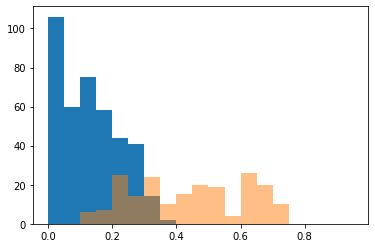

In [37]:
# Can also plot error as a function of mismatch

ra['fracerr'] = abs(ra['X_x']-ra['X_meas'])/ra['X_x']
# plt.scatter(abs(ra['z']-0.02),ra['inclination'],c=ra['fracerr'])
plt.hist(ra['fracerr'][loZ],bins=np.arange(20)/20.)
plt.hist(ra['fracerr'][~loZ],bins=np.arange(20)/20.,alpha=0.5)



In [38]:
# par = xbar['xbar'].distribution
# truth = xbar_table['xbar'][param_row]

par = xbar['X_0'].distribution
truth = xbar_table['X'][param_row]

plt.hist(par)
plt.axvline(truth,linestyle='--')


NameError: name 'xbar_table' is not defined

## 3.2 Two or more regular, consistent bursts

For the three sources in the reference burst sample ([http://adsabs.harvard.edu/abs/2017PASA...34...19G](Galloway et al. 2017)), we have moderately good constraints on the composition; so test how well the current analyses reproduce those values here

First read in the data from the reference burst sample; this is done as part of `concord`, where we define an arbitrary burst to trigger reading in the table (this could be achieved more simply)

In [39]:
# It doesn't matter which burst you choose here, I think; this is just
# to trigger concord to read the reference burst table

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)

i = 6 # select the first epoch burst from 1820
obs.table[i]

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
1997 May 4,3(1),1,$2.681\pm0.007$,$3.72\pm0.18$,$1.45\pm0.09$,0.144,$0.381\pm0.003$,$61\pm2$,$138.5\pm1.4$,4u1820-303_2.681h.dat


In [41]:
f_unit = u.erg/u.cm**2/u.s
nsamp = 1000

# Extract the data from this row and plot the alpha values

print (obs.table[i][0], obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

# Convert table strings to quantities (and errors, where available)
tdel = cd.decode_LaTeX(obs.table[i][3])
fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
bc = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

# if tdel[1] is None:
#     tdel = tdel[0]
# if bc[1] is None:
#     bc = bc[0]


1997 May 4 $2.681\pm0.007$ $3.72\pm0.18$ $1.45\pm0.09$ $0.381\pm0.003$


1997 May 4 (2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
[135.90349102  10.53291152  12.0924056 ]


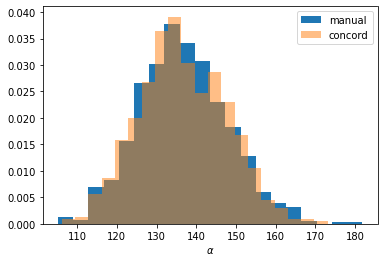

In [42]:
print (obs.table[i][0], tdel, (fluen, fluene), (fper, e_fper), bc)

alpha2 = cd.alpha(tdel*u.hr, (fluen, fluene), (fper, e_fper), bc, fulldist=True)
alpha2 = alpha2['alpha']

# Original (manual) calculation below, for comparison

_fluen = np.random.normal(loc=fluen, scale=fluene, size=nsamp)
_pflux = np.random.normal(loc=fper, scale=e_fper, size=nsamp)
if (np.shape(bc) != ()) & (bc[1] is not None):
    _bc = np.random.normal(loc=bc[0], scale=bc[1], size=nsamp)
else:
    _bc = bc
# Calculate alpha and plot the histogram

if (np.shape(tdel) != ()) & (tdel[1] is not None):
    _tdel =  (np.random.normal(0., 1., size=nsamp) * tdel[1] + tdel[0])*u.hr
else:
    _tdel *= u.hr
alpha = _pflux*f_unit/u.s*_bc*_tdel.to('s')/(_fluen*1000*f_unit)

# compare with the concord version

with quantity_support():
    plt.hist(alpha, bins=20, density=True, label='manual')
    #print (np.shape(tdel), np.shape())
    plt.hist(alpha2.distribution, bins=20, density=True, alpha=.50, label='concord')
plt.xlabel('$\\alpha$')
plt.legend()

ac = np.percentile(alpha2.distribution,[50,50-cd.CONF/2.,50+cd.CONF/2.])
print (cd.intvl_to_errors(ac))

1997 May 4 (2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
Acceptance fraction 56.50% of 1000 samples
[50.11414869 39.30198337 60.39659324 63.74595629] deg
[0.17948152 0.10089599 0.24285012 0.27309357]
[0.17948152 0.07858553 0.0633686 ]


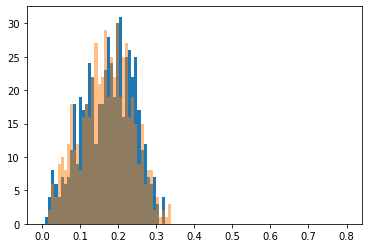

In [43]:
# Demonstrate result for one epoch

print (obs.table[i][0], tdel, (fluen, fluene), (fper, e_fper), bc)

xbar = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=bc, 
                    imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper

# can do a few different treatments for Z_CNO

Z_CNO = np.random.random(cd.NSAMP_DEF)*0.02
xbar_z = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=bc, zcno=Z_CNO,
                    imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper

xbar.keys()

pos = np.where(xbar['X_0'].distribution > 0.)[0]
pos_z = np.where(xbar_z['X_0'].distribution > 0.)[0]

print ('Acceptance fraction {:.2f}% of {} samples'.format(
    100*len(pos)/len(xbar['X_0'].distribution), len(xbar['X_0'].distribution)))

with quantity_support():
    plt.hist(xbar['X_0'].distribution[pos],bins=np.linspace(0,0.8,100))
    plt.hist(xbar_z['X_0'].distribution[pos_z],bins=np.linspace(0,0.8,100),alpha=0.5)
    # plt.hist(xbar['i'].distribution[pos],bins=np.linspace(0,90,90))
    # plt.plot(xbar['i'].distribution[pos], xbar['X_0'].distribution[pos],'.')
    # plt.axvline(34,linestyle='--',color='r')
    # plt.axvline(81,linestyle='--',color='r')
# print(np.linspace(0,0.8,100))
print (np.percentile(xbar['i'].distribution[pos],[50,50-cd.CONF/2.,50+cd.CONF/2.,95.]))
print (np.percentile(xbar['X_0'].distribution[pos],[50,50-cd.CONF/2.,50+cd.CONF/2.,95.]))
print (cd.intvl_to_errors(np.percentile(xbar['X_0'].distribution[pos],
                                       [50,50-cd.CONF/2.,50+cd.CONF/2.])))

6 $2.681\pm0.007$ $3.72\pm0.18$ $1.45\pm0.09$ $0.381\pm0.003$
(2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
95-percent upper limit on X_0 = 0.284 (594 samples)
7 $1.892^e$ $5.70\pm0.04$ 1.4981 $0.371\pm0.010$
(1.892, None) (0.371, 0.01) (5.7, 0.04) (1.4981, None)
95-percent upper limit on X_0 = 0.184 (473 samples)


Text(0.105, 10, ' Cumming (2003)')

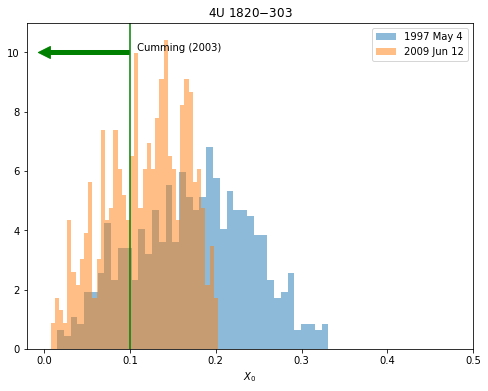

In [64]:
# First run goes through and does both 1820-30 bursts
plt.rcParams["figure.figsize"] = (8,6)

for i in np.arange(2)+6:
    print (i,obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    c_bol = cd.decode_LaTeX(obs.table[i][5])
    
    print (tdel, (fluen, fluene), (fper, e_fper), c_bol)
    
    # for the second pass, use the inclination as the prior for the second data set
    
    if i>6:
        xbar_com = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=c_bol, 
                               inclination=xbar['i'], fulldist=True) # inclination prior from previous run

    xbar = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=c_bol, 
                               imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper
# determine 95% limit on X_0

    g = np.where(xbar['X_0'].distribution >= 0)[0]
    plt.hist(xbar['X_0'].distribution[g], bins=40, alpha=0.5, density=True, label=obs.table[i][0])
    
    # if i>6:
    #     plt.hist(xbar_com['X_0'].distribution[g], bins=40, alpha=0.5, density=True, label='combined')


    xlim = np.percentile(xbar['X_0'].distribution[g],(18,50,84,95))

    print ('95-percent upper limit on X_0 = {:.3f} ({} samples)'.format(xlim[3], 
          len(g)))

plt.legend()
plt.xlim(-0.02,0.5)
plt.ylim(0, 11)
# plt.ylim(0,4)
plt.xlabel('$X_0$')
plt.title('4U 1820$-$303')
# plt.axvline(0.,linestyle='--',color='r')

# Show the limits for the last set of parameters
# plt.axvline(xlim[0],linestyle='--',color='g')
# plt.axvline(xlim[1],linestyle='-',color='g')
# plt.axvline(xlim[2],linestyle='--',color='g')

# Show the inferred limits from Cumming (2003)
plt.axvline(0.1,linestyle='-',color='g')
plt.annotate(' Cumming (2003)', xy=(-0.01, 10),  xycoords='data',
            xytext=(0.105, 10), textcoords='data',
            arrowprops=dict(facecolor='g', edgecolor='g', shrink=0.03),
            horizontalalignment='left', verticalalignment='bottom',
            )

# plt.savefig("fig1820.pdf", bbox_inches='tight')


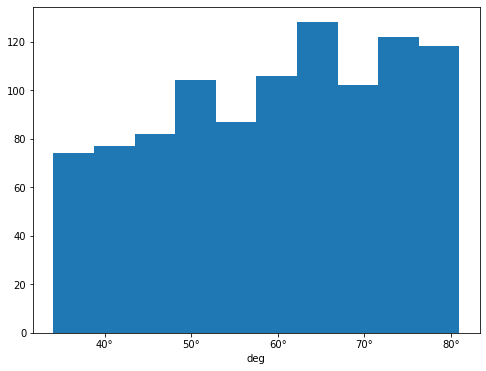

In [45]:
with quantity_support():
    plt.hist(xbar['i'].distribution)

The paper may only include the case of 4U 1820-30; also testing here with GS 1826-24

For GS 1826-24, Meisel et al. (2018) suggested an inclination of 65 or 80 deg; Johnston et al. (2020) found $i = 69^{+2}_{-3}$ degrees. Lack of dipping would suggest its $\lesssim75$

In [46]:
# Now try one of the epochs for 1826-24

i = 0 # select the first epoch burst from 1826
obs.table[i]

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
1998 Jun,6(1),7,$5.14\pm0.07$,$1.167\pm0.006$,$1.806\pm0.009$,0.0513,$1.102\pm0.011$,$30.9\pm1.0$,$34.2\pm0.5$,gs1826-24_5.14h.dat


$3.530\pm0.004$ $1.87\pm0.02$ $1.751\pm0.003$ $1.18\pm0.04$
(5.14, 0.07) 1.102 1.167 (1.806, 0.009)
(4.177, 0.01) 1.126 1.593 (1.787, 0.003)
(3.53, 0.004) 1.18 1.87 (1.751, 0.003)


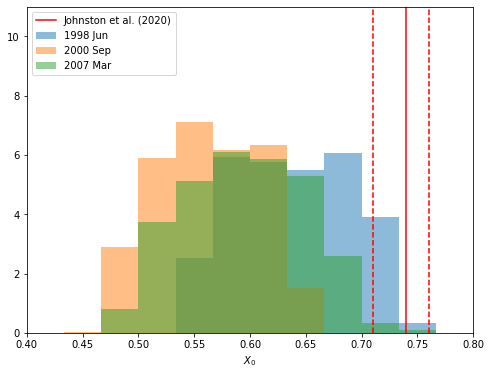

In [62]:
print (obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

# Loop over the three epochs and determine the X_0 distribution for each one, comparing with
# Johnston et al. 20

for i in range(3):
    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    print (tdel, fluen, fper, (bc, bce))

    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar = cd.hfrac(tdel*u.hr, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=(bc, bce), imin=66, imax=71,
                   fulldist=True)#, imin=65, imax=80)
    plt.hist(xbar['X_0'].distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/30.,density=True)

plt.xlabel('$X_0$')
plt.axvline(0.74,color='r',label='Johnston et al. (2020)') # central value from johnston20
plt.axvline(0.74-0.03,color='r',linestyle='--')
plt.axvline(0.74+0.02,color='r',linestyle='--')
plt.xlim(0.4,0.8)
plt.ylim(0,11)
plt.legend()

In [65]:
# This plot shows the dependence of the inferred composition on the inclination, for one
# epoch

xbar, X_0, incl = cd.hfrac(tdel, alpha, imin=65, imax=80)#, debug=True)
plt.plot(incl.distribution,X_0.distribution,'.')
plt.axvline(69,color='r')
plt.axvline(69-3,color='r',linestyle='--')
plt.axvline(69+2,color='r',linestyle='--')

TypeError: unsupported operand type(s) for /: 'float' and 'dict'

In [12]:
# Now try the 3 epochs for 1808-369

i = 3 # select the first epoch burst from 1826
obs.table[i]

# fper, e_fper = tex2val(obs.table[i][4])
# print (fper, e_fper)

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
2002 Oct,1(1),2,$16.55\pm0.06^c$,2.541--2.298,$2.085\pm 0.019$,0.0472$^d$,$2.649\pm0.018$,$229\pm4$,$114.4\pm1.9$,saxj1808.4-3658_16.55h.dat


3 2.541 2.298
(16.55, 0.06) 2.649 2.4195 (2.085, 0.019)
** WARNING ** this quantity is already a distribution
4 2.298 1.946
(21.1, None) 2.99 2.122 (2.13, 0.04)
** WARNING ** this quantity is already a distribution
5 1.946 1.826
(29.82, None) 3.46 1.8860000000000001 (2.157, 0.002)
** WARNING ** this quantity is already a distribution


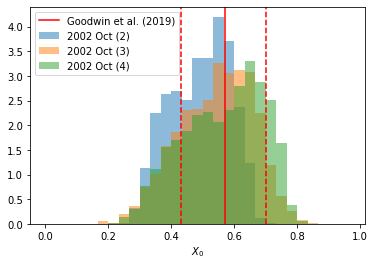

In [13]:
# Loop over the three epochs and determine the X_0 distribution for each one, comparing with
# Goodwin et al. 2019
# Wang et al. (2013) had i=50^{+6}_{-5}, Cackett et al. (2009) had 55^{+8}_{-4}
# Select a conservative range of inclinations covering both ranges

for i in np.arange(3)+3:
    tdel = cd.decode_LaTeX(obs.table[i][3])
    # persistent flux is given as a range not value with error
    # fper, e_fper = tex2val(obs.table[i][4])
    fmin, fmax = cd.decode_LaTeX(obs.table[i][4])
    # print (i, fmin, fmax)
    fper, e_fper = 0.5*(fmin+fmax), 0.5*(fmax-fmin)
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    print (tdel, fluen, fper, (bc, bce))

    alpha = cd.alpha(tdel, (fluen, fluene), (fper, e_fper), (bc, bce))
    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar, X_0, incl = cd.hfrac(tdel, alpha, imin=45, imax=63)#, debug=True)
    plt.hist(X_0.distribution,alpha=0.5,label=obs.table[3][0]+' ('+str(i-1)+')',bins=np.arange(30)/30.,density=True)

plt.xlabel('$X_0$')
plt.axvline(0.57,color='r',label='Goodwin et al. (2019)') # central value from johnston20
plt.axvline(0.57-0.14,color='r',linestyle='--')
plt.axvline(0.57+0.13,color='r',linestyle='--')
# plt.xlim(0.4,0.8)
# plt.ylim(0,11)
plt.legend()

## 3.3 One (or more) bursts, no recurrence times

See the example for XMMU J181227.8-181234 below. Here 6 bursts were observed over an exposure time of 0.3446 d, with many gaps in between. So we compute a distribution of mean recurrence times consistent with the measurements, and propagate this distribution through to the rest of the calculation

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
Synthetic distribution of tdel has 1.378_-0.514^0.488 h


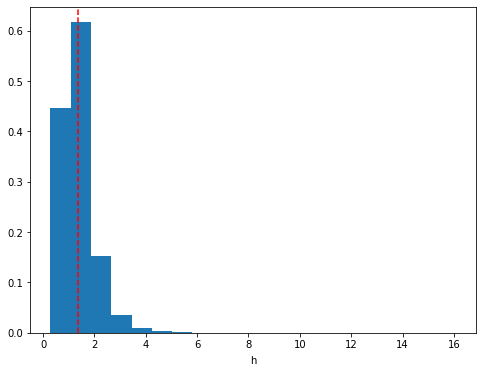

In [66]:
# Observations

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

fluen, fluene = 0.0241, 0.0073 # 1e-6 erg/cm^2
# fluen *= 2. # for testing
# fluene *=2.
# tdel, tdel_err = 1.38*u.hr, 0.56*u.hr
pflux, pfluxe = 1.19, 0.16 # 1e-9 erg/cm^2/s
bc = 2.522
f_unit = 1e-9*u.erg/u.cm**2

# Assumptions here

opz_def = cd.redshift(1.4*const.M_sun,11.2*u.km)

xmax = 0.77
zcno_def = 0.02
# zcno_def = 0.05 # acceptance fraction up to 13%
nbin=1000000 # for paper plots
# nbin=2000 # for testing

# some tests here

# opz_def*=1.1

z_def = opz_def-1.
print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

# Estimate tdel and error based on Poisson stats
# could package this up into a function
    
tdel_arr = cd.tdel_dist(nburst, exp, nsamp=nbin)
tdel = exp/nburst

# lim = np.percentile(y,(16,50,84))
lim = np.percentile(tdel_arr.distribution,(16,50,84))
# print (lim[1],lim[0],lim[2])
# print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
#     tdel.value,(exp/lim[2]-tdel).value,exp/lim[0]-tdel))
print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
    tdel.value,(lim[0]-tdel).value,lim[2]-tdel))

with quantity_support():
    plt.hist(tdel_arr.distribution,bins=20,density=True)
    plt.axvline(tdel,linestyle='--',color='r')

1000000 1000000
alpha = 573.38 (68% range 351.44-1003.43)


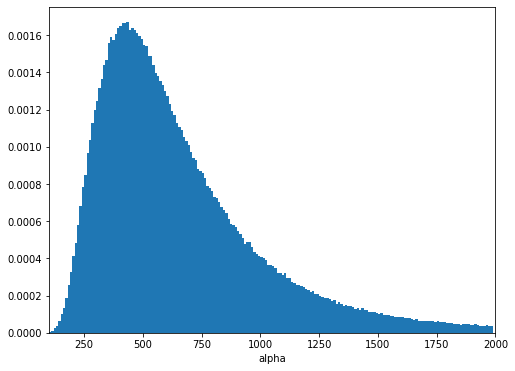

In [67]:
# Calculate alpha and plot the histogram, using the concord routine

# alpha = pflux*f_unit/u.s*bc*tdel.to('s')/(fluen*f_unit)
alpha = cd.alpha(tdel_arr,(fluen,fluene),(pflux,pfluxe),bc, fulldist=True)
alpha['alpha'].distribution

print(cd.len_dist(tdel_arr), cd.len_dist(alpha['alpha']))
with quantity_support():
    plt.hist(alpha['alpha'].distribution,bins=np.arange(0,2000,10),density=True)
plt.xlabel('alpha')
plt.xlim(100,2000)
# print (len(alpha))
# print (np.isscalar(alpha[3]))

# Also show the statistics

ap = np.percentile(alpha['alpha'].distribution,(16,50,84))
print ("alpha = {:.2f} (68% range {:.2f}-{:.2f})".format(ap[1],ap[0],ap[2]))

# print (len(alpha))

1000000 1000000
22391 1000000
Accepting 2.2391% of samples
For assumed 1+z = 1.2590, Z_CNO = 0.020, X_0 = 0.0525_0.0262^0.1032 (< 0.1576 @ 95%)
i = 51.0_28.2^67.8 deg


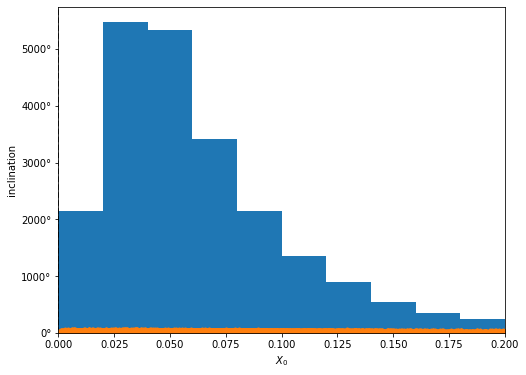

In [68]:
# Now calculate the H-fraction at ignition, and the corresponding fuel composition
# and sytem inclination. Make sure to include fulldist=True to get the distributions

Z_CNO = np.random.random(nbin)*0.02

print (cd.len_dist(tdel_arr), cd.len_dist(alpha['alpha']) )
# Initial version of this calculation just used the fixed value of Z_CNO; but here
# we follow the earlier analysis by having a randomly distributed set of values
xbar = cd.hfrac(tdel_arr,alpha['alpha'],1+z_def,
                # zcno=zcno_def,
                zcno=Z_CNO,
                isotropic=False,fulldist=True)#,debug=True)

# cd.len_dist(tdel_arr), cd.len_dist(alpha), cd.len_dist(_x_0)

plt.hist(xbar['X_0'].distribution,bins=np.arange(0.,0.3,0.02))
plt.xlim(-0.1,0.8)
# plt.ylim(0,200)
plt.xlabel('inferred X_0')
plt.axvline(x=xmax,linestyle='--',color='k')
plt.axvline(x=0,linestyle='--',color='k')

good=np.where(np.logical_and(xbar['X_0'].distribution <= xmax,xbar['X_0'].distribution > 0))[0]
print (len(good), cd.len_dist(alpha['alpha']))

# Stats on the accepted samples

print ("Accepting {}% of samples".format(
    100.*len(good)/cd.len_dist(alpha['alpha'])))

# Display results
xp = np.percentile(xbar['X_0'].distribution[good],(50,16,84,95))
print ("For assumed 1+z = {:.4f}, Z_CNO = {:.3f}, X_0 = {:.4f}_{:.4f}^{:.4f} (< {:.4f} @ 95%)".format(
    1+z_def,zcno_def,xp[0], xp[1], xp[2], xp[3]))
ip = np.percentile(xbar['i'].distribution,(50,16,84))
print ("i = {:.1f}_{:.1f}^{:.1f}".format( ip[0].value, ip[1].value, ip[2]))

with quantity_support():
    # "bad" values are returned as -1, so no need to highlight the "good"
    plt.plot(xbar['X_0'].distribution,xbar['i'].distribution,'.')
    plt.xlim(0,0.2)
    plt.xlabel('$X_0$')
    plt.ylabel('inclination')
    # plt.plot(_x_0.distribution[good],i.distribution[good],'.')

In [7]:
xbar.keys()

dict_keys(['xbar', 'X_0', 'i', 'alpha', 'fluen', 'fper', 'model'])

In [21]:
# Here we write out all the results
# This doesn't work yet...

print (cd.len_dist(tdel_arr),cd.len_dist(alpha),
       # cd.len_dist(_x_0),cd.len_dist(i),cd.len_dist(xbar)
       cd.len_dist(xbar['X_0']), cd.len_dist(xbar['i']), cd.len_dist(xbar['xbar']))
# xi_p, xi_b = cd.diskmodel.anisotropy(i)
xi_p, xi_b = cd.diskmodel.anisotropy(xbar['i'])

# d = {'fluen': fluen, 'pflux': pflux, 'tdel': tdel_arr, 'alpha': alpha,
d = {'tdel': tdel_arr.distribution, 'alpha': alpha['alpha'].distribution,
     # 'xbar': xbar, 'x_0': _x_0, 'theta': i, 
     'xbar': xbar['xbar'].distribution, 'x_0': xbar['X_0'].distribution, 'theta': xbar['i'].distribution,
     'xi_p': xi_p.distribution, 'xi_b': xi_b.distribution}

results = pd.DataFrame(data = d)
# plt.hist(results['alpha'],bins=100)
# results.to_csv('1812-182_sim_results.csv')

In [22]:
# and display, copying the approach from the previous source

data = np.vstack((xbar['xbar'].distribution[good], 
                  xbar['X_0'].distribution[good], 
                  Z_CNO[good], 
                  tdel_arr.distribution[good].value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=labels).plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='xmmuj181227.8-181234.pdf'
                                )

RuntimeError: latex was not able to process the following string:
b'$X_0 = 0.041^{+0.051}_{-0.033}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_0) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/duncan/.matplotlib/tex.cache/7197afe9c3b3fca955774bf4f6fb6e2a.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 7197afe9c3b3fca955774bf4f6fb6e2a.log.




RuntimeError: latex was not able to process the following string:
b'$X_0 = 0.041^{+0.051}_{-0.033}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_0) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/duncan/.matplotlib/tex.cache/7197afe9c3b3fca955774bf4f6fb6e2a.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 7197afe9c3b3fca955774bf4f6fb6e2a.log.




<Figure size 576x576 with 16 Axes>

## 3.4 One burst – estimating the distance and burst rate

Here I follow through the analysis of the (single) burst from IGR J17591-2342, from Table 3 of Kuiper et al. 2020 (https://arxiv.org/abs/2002.12154)

In [6]:
src = 'IGR J17591-2342'
t0 = 58380.96358 # MJD
instr = 'IJ1'

F_pk, F_pk_err = 76., 14. # 1e-9 erg/cm^2/s
F_pers, F_pers_err = 1.2, 0.2 # 1e-9 erg/cm^2/s
E_b, E_b_err = 1.1, 0.1 # 1e-6 erg/cm^2

Distance limits including inclination constraint 7.70 kpc_-0.64 kpc^+0.83 kpc kpc (100000 samples);
  with burst anisotropy factor averaging xi_b = 0.70


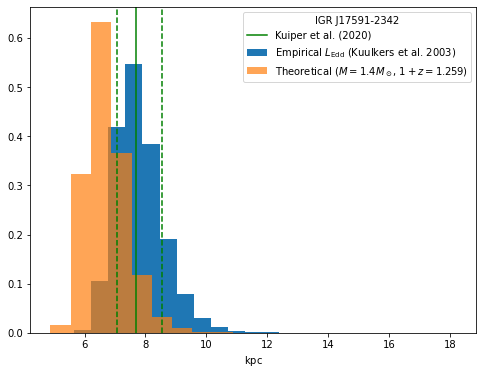

In [7]:
# There is a rough limit of 28-30 degrees for the inclination
# We can use that to constrain the various system parameters we've derived
# Use 100000 samples to make the figure for publication, with slightly smoother
# distributions
# Below we also illustrate two different ways to provide the units on the flux

dist_theo = cd.dist((F_pk, F_pk_err)*flux_unit*1e-9, empirical=False, fulldist=True, 
                    imin=24, imax=30, nsamp=100000)

dist2 = cd.dist((F_pk, F_pk_err), empirical=True, fulldist=True, 
                imin=24, imax=30, nsamp=100000)

fig2 = plt.figure()
fig2.set_size_inches(8,6)

with quantity_support():
    plt.hist(dist2['dist'].distribution,density=True,bins=20,label="Empirical $L_\mathrm{Edd}$ (Kuulkers et al. 2003)")

    plt.hist(dist_theo['dist'].distribution,density=True,bins=20,alpha=0.7,
            label='Theoretical ($M=1.4 M_\odot$, $1+z=1.259$)')
    
dper = np.percentile(dist2['dist'].distribution,(50,16,84))
plt.axvline(dper[0],color='g', label='Kuiper et al. (2020)')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')
# xiper = np.percentile(dist2['xi_b'][g],(50,16,84))

# These values for the paper

print ('''Distance limits including inclination constraint {:.2f}_{:.2f}^{:+.2f} kpc ({} samples);
  with burst anisotropy factor averaging xi_b = {:.2f}'''.format(
    dper[0], dper[1]-dper[0], dper[2]-dper[0], len(dist2['dist'].distribution),
    np.mean(dist2['xi_b'].distribution)))

plt.legend(title=src)

# fig2.savefig("fig2.pdf", bbox_inches='tight')

In [8]:
# Estimate the accretion rate

print (F_pers)
m2 = cd.mdot((F_pers,F_pers_err),dist2['dist'],inclination=dist2['i'],fulldist=True)#,nsamp=2000)

mdot = np.percentile(m2['mdot'].distribution,(50,16,84))
print ('''
Accretion rate implied from persistent flux, with xi_p = {:.2f} (average) is {:.0f}_{:.0f}^{:+.0f} 
  or {:.3f}_{:.3f}^{:+.3f} in units of the Eddington accretion rate'''.format(
    np.mean(m2['xi_p'].distribution),
    mdot[0].value,(mdot[1]-mdot[0]).value,mdot[2]-mdot[0], #m2['mdot'].unit,
    (mdot[0]/mdot_Edd).value,((mdot[1]-mdot[0])/mdot_Edd).value,(mdot[2]-mdot[0])/mdot_Edd))

# len(m2['mdot'].distribution)

1.2

Accretion rate implied from persistent flux, with xi_p = 0.47 (average) is 1928_-423^+567 g / (cm2 s) 
  or 0.022_-0.005^+0.006 cm2 / cm2 in units of the Eddington accretion rate


This calculation determines the ignition column; in the absence of a value for Xbar, a random distribution of values is used. A uniform distribution of Xbar is not realistic, but it's hard to do better. Also, large values of Xbar are suppressed by the limit on X_0, down the track

In [9]:
# The size of the distribution has to be consistent with the distance array
nsamp = cd.len_dist(dist2['dist'])
# print (nsamp)

Xbar = unc.uniform(lower=0.0*u.dimensionless_unscaled, upper=0.7*u.dimensionless_unscaled,
                  n_samples=nsamp)

# Calculate the ignition column

y2 = cd.yign((E_b, E_b_err), dist2['dist'], inclination=dist2['i'], 
             Xbar=Xbar, fulldist=True)

# Now the recurrence time

dt1 = y2['yign']/m2['mdot']*cd.OPZ
# print (type(dt1))

In [10]:
# The combination of Xbar and recurrence time constrain X_0 and Z_CNO. 
# For each pair, we calculate the values here

Z_CNO = np.random.random(nsamp)*0.02

x_0 = np.zeros(nsamp)
for i in range(nsamp):
    # print (i,Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))
    x_0[i] = cd.X_0(Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))

# We restrict to physical values i.e. x_0 < 0.75

g = np.where(x_0 < 0.75)[0]

print ('Acceptance fraction {:.2f}% of {} samples'.format(100*len(g)/len(x_0), len(x_0)))

Acceptance fraction 61.39% of 100000 samples


Now we can display all the values of yign, and dt1 that meet the criterion on x_0 imposed above

In [11]:
# display results for the realistic subset of the distributions

yign = np.percentile(y2['yign'].distribution[g]/1e8,(50,16,84))
print('''
Ignition column is {:.2f}_{:.2f}^{:+.2f} e8 {}'''.format(
    yign[0].value,(yign[1]-yign[0]).value,(yign[2]-yign[0]).value,y2['yign'].unit))

dtc = np.percentile(dt1.distribution[g].to('d').value, (50,16,84))
print('''
Inferred recurrence time is {:.2f}_{:.2f}^{:+.2f} d'''.format(
    dtc[0], dtc[1]-dtc[0], dtc[2]-dtc[0]))


Ignition column is 1.66_-0.62^+1.04 e8 g / cm2

Inferred recurrence time is 1.21_-0.45^+0.78 d


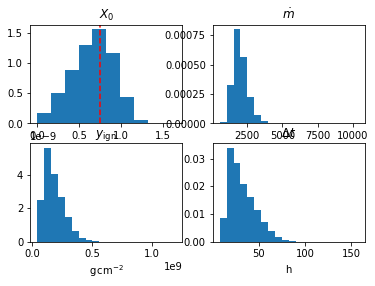

In [12]:
# Ugly but informative plot

fig3, axs3 = plt.subplots(2, 2)
with quantity_support():
    axs3[0,0].hist(x_0, density=True)
    axs3[0,0].set_title('$X_0$')
    axs3[0, 0].axvline(0.75,color='r',linestyle='--')

    axs3[0, 1].hist(m2['mdot'].distribution[g], bins=20, density=True)
    axs3[0, 1].set_title('$\dot{m}$')
    
    axs3[1, 0].hist(y2['yign'].distribution[g], bins=20, density=True)
    axs3[1, 0].set_title('$y_\mathrm{ign}$')
    
    axs3[1, 1].hist(dt1.distribution[g].to('hr'), bins=20, density=True)
    axs3[1, 1].set_title('$\Delta t$')

In [14]:
# using instead chainconsumer to plot; see 
# https://samreay.github.io/ChainConsumer/examples/customisations/plot_one_chain.html

data = np.vstack((Xbar.distribution[g].value, 
                  x_0[g], 
                  Z_CNO[g], 
                  dt1.distribution[g].to('d').value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=labels).plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='igrJ17591-2342.pdf'
                                )

RuntimeError: latex was not able to process the following string:
b'$\\\\overline{X} = 0.049^{+0.321}_{-0.047}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_0) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/duncan/.matplotlib/tex.cache/2ed593badf073c8eba61679c88dba7a9.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 2ed593badf073c8eba61679c88dba7a9.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\overline{X} = 0.049^{+0.321}_{-0.047}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_0) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/duncan/.matplotlib/tex.cache/2ed593badf073c8eba61679c88dba7a9.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 2ed593badf073c8eba61679c88dba7a9.log.




<Figure size 576x576 with 16 Axes>

In [40]:
import pickle

with open("analysis.p","wb") as f:
    pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
        nsamp, dist2), f)
#     pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
#         nsamp, dist_theo, dist2, m2, y2, Xbar, x_0, Z_CNO, dt1, g), f)
type(dist_theo['dist'])



PicklingError: Can't pickle <class 'astropy.uncertainty.core.QuantityDistribution'>: attribute lookup QuantityDistribution on astropy.uncertainty.core failed

## 3.5 Zero bursts  – constraining  the distance

Here we compare the results from a study of the accretion-powered millisecond pulsar IGR J00291+5934, as published in gal06b; along with pointers to Adelle's version of settle. Can compare the earlier work with the subsequent detection of a burst from the source [kuin15](http://www.astronomerstelegram.org/?read=7849), with distance derivation (via the `dist` method).

Note also the additional clause when plotting the distribution objects, to provide the unit support; see https://docs.astropy.org/en/stable/uncertainty

In [4]:
src = 'IGR J00291+5934'
F_pk, F_pk_err = 18, 4 # 1e-8 erg/cm^2/s; 

gal06b = (3.9, 5.2) # llim, ulim (@ 3-sigma), for X=0.7
          
# F_pk *= 1e-8*flux_unit
# F_pk_err *= 1e-8*flux_unit

# Generate the distance distributions based on the peak flux, and the
# empirical Eddington luminosity; two options here, the first with no
# constraints on the inclination, the second imposing the inferred
# inclination range of torres08, of 22-32 degrees

dist_all = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True)

dist = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True, imin=22, imax=32)#, plot=True)

# Display the best estimate of the plausible range

dper = np.percentile(dist['dist'].distribution,(50,16,84))
print ('''Distance range including inclination constraints is {:.2f}_{:.2f}^{:.2f} kpc
  incorporates model-predicted anisotropy averaging xi_b = {:.3f}'''.format(
    dper[0],(dper[1]-dper[0]),dper[2]-dper[0],np.mean(dist['xi_b'].distribution)))

# Show the fraction of samples beyond 5 kpc (why?)
print (len(np.where(dist['dist'].distribution > 5.*u.kpc)[0])/len(dist['dist'].distribution))

Distance range including inclination constraints is 5.00 kpc_-0.50 kpc^0.69 kpc kpc
  incorporates model-predicted anisotropy averaging xi_b = 0.705
0.5


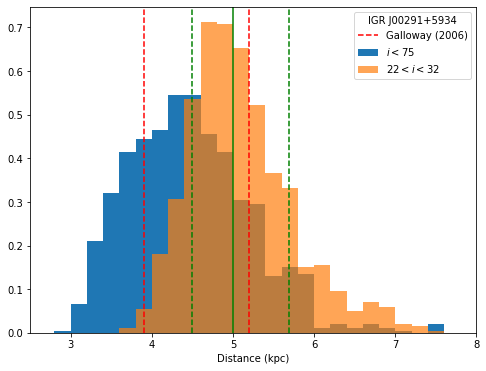

In [5]:
# Plot to compare the 2 distributions

fig1 = plt.figure()
fig1.set_size_inches(8,6)
with quantity_support():
    plt.hist(dist_all['dist'].distribution,bins=np.arange(40)/5.,density=True, 
         label='$i<{:.0f}$'.format(cd.IMAX_NDIP))

    plt.hist(dist['dist'].distribution,bins=np.arange(40)/5.,alpha=0.7,density=True,
        label='${:.0f}<i<{:.0f}$'.format(22,32))
plt.xlim(2.5,8)
plt.xlabel('Distance (kpc)')
# plt.text(7.7, .67, src, horizontalalignment='right')

plt.axvline(dper[0],color='g')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')

plt.axvline(gal06b[0],color='r',ls='--',label='Galloway (2006)')
plt.axvline(gal06b[1],color='r',ls='--')

plt.legend(title=src)

# fig1.savefig("fig1.pdf", bbox_inches='tight')

## 3.6 Observation-model comparisons

Here we provide examples of model-observation comparisons

The simplest case is where we use a code like `settle` which predicts burst recurrence time and fluence, for a given accretion rate. We describe below how to do the comparison _to be written_

In [43]:
# for the 1820-30 observations on 1997 May 27

d = 7.6*u.kpc
i = 50*u.deg
X_0 = 0.17
Z_CNO = 0.02

# We use the inferred mdot as the input value for the simulations, but in principle
# any value can be used

mdot = 0.144 # in units of mdot_Edd

# this is how we would convert to mdot in g/s/cm^2 as used internally in settle
# mdot *= 1.75*(1.7/(1+X_0))*(1e-8)*(5.01837638e24*u.g/u.s)/(11.2*u.km)**2
# but gal17a throughout uses a fixed value of 8.8×10^4 g cm−2 s−1
mdot *= 8.8e4*u.g/u.cm**2/u.s * 4.*np.pi*(11.2*u.km)**2
# mdot.to('g s-1')# cm-2')

# Settle model predictions give the following
# >>> settle(0.15, 0.02, 0.17, 0.144, 1, 1.4, 11.2)
# rec.array([(2.24151435, 3.13472479, 161.05916546)],
#           dtype=[(‘tdel’, ‘<f8’), (‘E_b’, ‘<f8’), (‘alpha’, ‘<f8’)])

# Initially I wanted to set z=0 because the settle results might already be redshifted
# but this will result in Q_grav = 0.0
# cd.fper(mdot, (d, i, 1.0, 0.0))

fper_mod = cd.fper(mdot, (d, i, cd.OPZ, 0.0), c_bol=1.45)
# Use lum_to_flux to convert the burst energy to fluence; note the burst flag is set
fluen_mod = cd.lum_to_flux(3.13472479*1e39*u.erg/u.s, d, inclination=i, c_bol=1.,
                           burst=True)*u.s

# Now print out the comparison; this uses the values from a few cells up

print (' Model | Observation  \n-----------------------')
print (' {:.3f} | {:.3f}+/-{:.3f}'.format(fper_mod*1e9/(flux_unit), fper, e_fper))
print (' {:.3f} | {:.3f}+/-{:.3f}'.format(2.24151435, tdel[0], tdel[1]))
print (' {:.3f} | {:.3f}+/-{:.3f}'.format(fluen_mod*1e6/(u.erg/u.cm**2), fluen, fluene))

 Model | Observation  
-----------------------
 3.258 | 3.720+/-0.180
 2.242 | 2.681+/-0.007
 0.505 | 0.381+/-0.003


The full comparison is where we also incorporate the comparison of the lightcurve. That's described here (for a different source)

We use one of the "reference" bursts described by [http://adsabs.harvard.edu/abs/2017PASA...34...19G](Galloway et al. 2017), provided the data is available in the `data` subdirectory of the concord repo.

In [2]:
# First read in some test data and generate an ObservedBurst object

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)


ObservedBurst parameters:
  tdel = 3.5300 h
  Fluence = 1.237e-06 +/- 9.400e-09 erg / cm2
  F_per = 1.8700e-09 erg / (cm2 s) +/- 2.0000e-11 erg / (cm2 s)
  Bolometric correction = 1.751
Lightcurve properties
  filename = gs1826-24_3.530h.dat
  time range = (-2.250 s,211.433 s)
  flux range = (2.300e-10 erg / (cm2 s),2.757e-08 erg / (cm2 s))


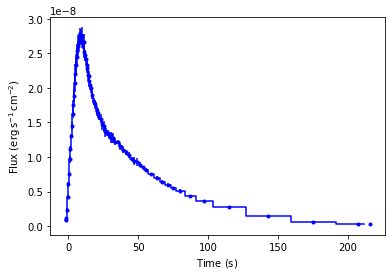

In [3]:
obs.plot()

obs.info()

In [28]:
# Now choose some random model for comparison; from Zach, 27/4/17
# after a few more bursts each:
#
# gs1   4.06 +/- 0.17
# gs2   5.30 +/- 0.17
# gs3   3.32 +/- 0.07
#
# and I've attached the newer mean lightcurves in case you also want them.
#
# Redshift is still 1.259
# 
# Mass and radius used in Kepler is 1.4 Msun and 10km, which corresponds to 11.2km radius in GR (with same mass). 
# Gravity is 1.858e+14 (cgs)
# 
# > On 27 Apr 2017, at 3:53 PM, Zac Johnston Johnston <zac.johnston@monash.edu> wrote:
# >
# > The follow ups are still running but they've got ~10 bursts each now so probably enough to have a look.
# >
# > #mod     acc rate        Z             H             Lacc/Ledd  ||  recurrence time (hr)
# > gs1   2.037000e-09    0.0050    0.7000    0.1164        ||  4.1 +/- 0.1
# > gs2   1.654625e-09    0.0050    0.7000    0.0945        ||  5.4 +/- 0.2
# > gs3   2.409750e-09    0.0050    0.7000    0.1377        ||  3.3 +/- 0.1

M_NS, R_NS = 1.4*const.M_sun, 11.2*u.km

opz = cd.redshift(M_NS, R_NS)


c_loZ = cd.KeplerBurst(filename='mean3.data',path='concord/data',
                  lAcc=0.1164,Z=0.005,H=0.7,
                  tdel=3.32/opz,tdel_err=0.07/opz,
                  g = 1.858e+14*u.cm/u.s**2, R_NS=11.2*u.km) # R_Newt=10*u.km) # would be more precise

<class 'concord.burstclass.KeplerBurst'> 4.0503909066119305e+21 kg / yr

KeplerBurst parameters:
  tdel = 2.637 h
  g = 1.8580e+14 cm / s2
  R_Newt = 9.986 km
  R_NS = 11.200 km
  1+z = 1.258
Lightcurve properties
  filename = mean3.data
  time range = (-20.222 s,160.009 s)
  luminosity range = (3.689e+35 erg / s,1.969e+38 erg / s)


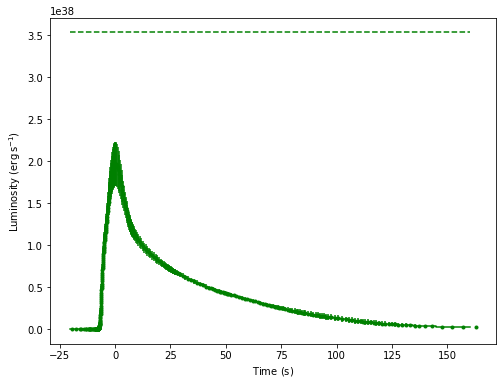

In [29]:
print (type(c_loZ), c_loZ.mdot)

c_loZ.plot()

c_loZ.info()

In [30]:
cd.mdot_Edd()

AttributeError: module 'concord' has no attribute 'mdot_Edd'

6851.648062937555


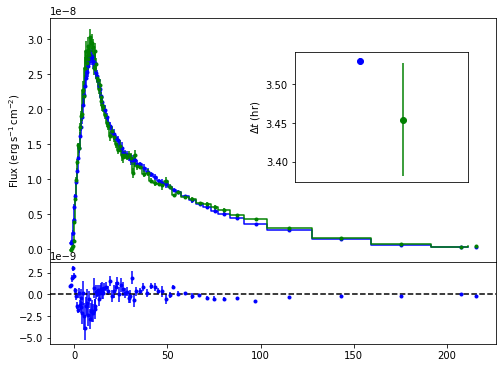

In [35]:
# plt.title('GS 1826$-$24')

l = obs.compare(c_loZ,param = [7.5*u.kpc,60.*u.degree,1.31,-6.5*u.s], plot=True)

plt.rcParams["figure.figsize"] = (8,6)

print (l)
# plt.savefig("lc_comp.pdf", bbox_inches='tight')